# Modélisation du prix des maisons

Ce notebook documente l'ensemble du flux de travail : exploration des données, préparation, entraînement de modèles réutilisable pour l'application Streamlit.

## 1. Importation des librairies et configuration
Nous commençons par charger les packages nécessaires pour l'analyse exploratoire et la modélisation.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Chargement des données
Nous utilisons les fichiers `train.csv` et `test.csv` fournis. La variable cible est `SalePrice` dans l'échantillon d'entraînement.

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.shape, test_df.shape

((1460, 81), (1459, 80))

## 3. Aperçu des données
Un premier coup d'œil sur les colonnes principales permet d'identifier rapidement la structure du jeu de données.

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.describe(include='all').transpose().iloc[:15]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Données manquantes
Nous calculons le pourcentage de valeurs manquantes par colonne et visualisons les variables les plus touchées.

In [5]:
missing_ratio = (train_df.isnull().mean() * 100).sort_values(ascending=False)
missing_ratio.head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
dtype: float64

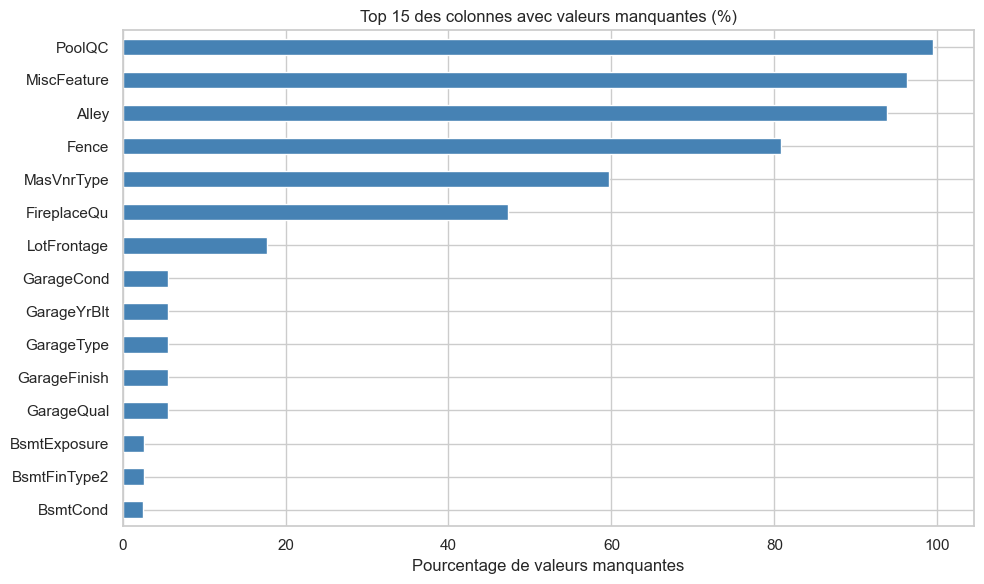

In [6]:
top_missing = missing_ratio.head(15).sort_values()
ax = top_missing.plot(kind='barh', color='steelblue')
ax.set_title('Top 15 des colonnes avec valeurs manquantes (%)')
ax.set_xlabel('Pourcentage de valeurs manquantes')
plt.tight_layout()

## 5. Analyse de la variable cible
`SalePrice` présente une distribution asymétrique ; nous observons également sa version log-transformée pour stabiliser la variance.

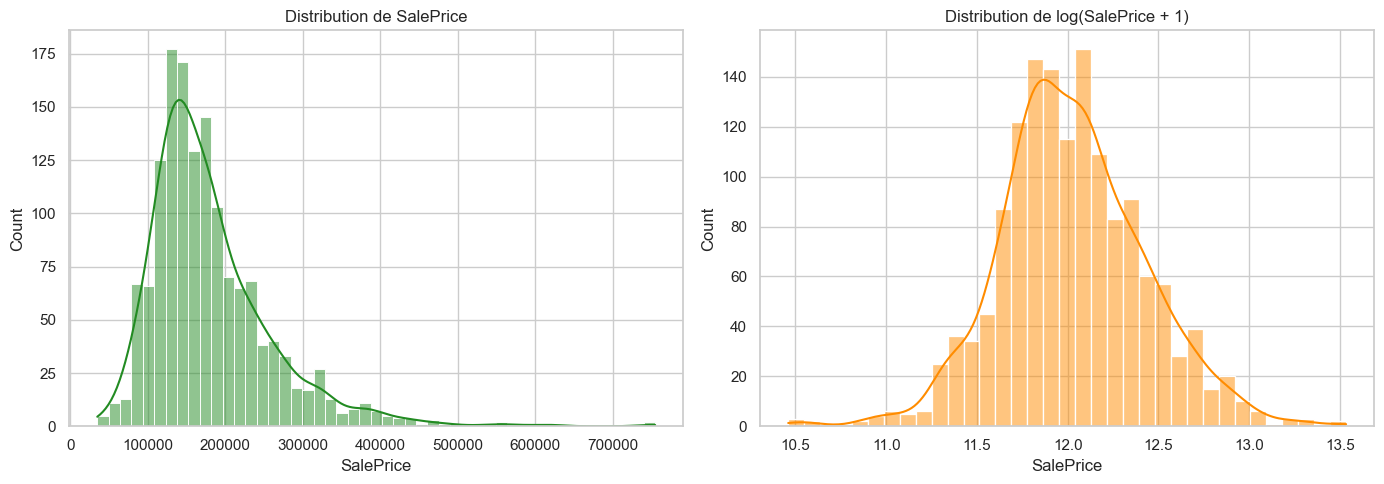

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['SalePrice'], kde=True, ax=axes[0], color='forestgreen')
axes[0].set_title('Distribution de SalePrice')
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Distribution de log(SalePrice + 1)')
plt.tight_layout()

## 6. Colonnes numériques et catégorielles
Nous séparons les variables numériques et catégorielles afin de définir des pipelines de prétraitement adaptés.

In [8]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = [col for col in train_df.columns if col not in categorical_cols + ['SalePrice']]

print(f"Variables numériques ({len(numeric_cols)}): {numeric_cols[:10]}{'...' if len(numeric_cols) > 10 else ''}")
print(f"Variables catégorielles ({len(categorical_cols)}): {categorical_cols[:10]}{'...' if len(categorical_cols) > 10 else ''}")

Variables numériques (37): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']...
Variables catégorielles (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...


## 7. Corrélations avec la cible
Nous observons les variables numériques les plus corrélées avec `SalePrice` pour guider l'interprétation.

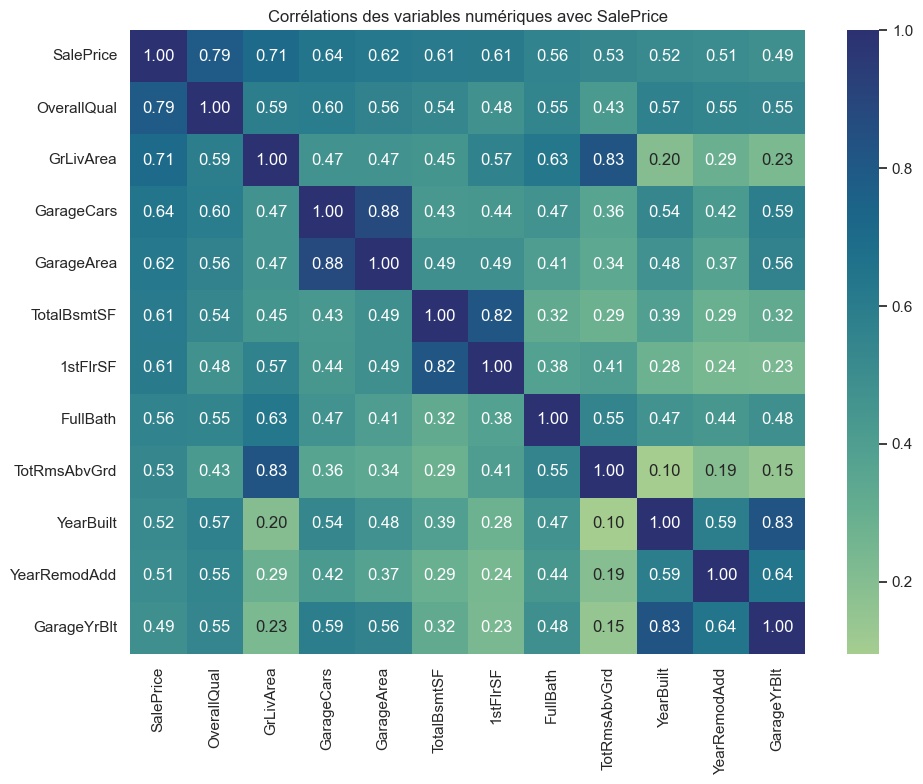

In [9]:
corr_matrix = train_df[numeric_cols + ['SalePrice']].corr()
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(12).index

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_corr, top_corr], annot=True, fmt='.2f', cmap='crest')
plt.title('Corrélations des variables numériques avec SalePrice')
plt.tight_layout()

## 8. Prétraitement
- **Numérique :** imputation par la médiane.
- **Catégoriel :** imputation par la modalité la plus fréquente, puis encodage *one-hot* avec gestion des modalités inconnues.

La séparation entre `X` et `y` est réalisée avant la division en apprentissage/test.

In [10]:
X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((1168, 80), (292, 80))

## 9. Fonction d'évaluation
Pour comparer les modèles, nous utilisons la RMSE (erreur quadratique moyenne racine), la MAE et le coefficient $R^2$.

In [13]:
def evaluate(model, X_tr, y_tr, X_te, y_te):
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_te)

    metrics = {
        # Correction ici : on prend la racine carrée manuellement
        'RMSE_train': np.sqrt(mean_squared_error(y_tr, pred_train)),
        'MAE_train': mean_absolute_error(y_tr, pred_train),
        'R2_train': r2_score(y_tr, pred_train),
        'RMSE_test': np.sqrt(mean_squared_error(y_te, pred_test)),
        'MAE_test': mean_absolute_error(y_te, pred_test),
        'R2_test': r2_score(y_te, pred_test),
    }
    return pd.Series(metrics)

## 10. Modèle 1 : Random Forest Regressor
Forêt aléatoire robuste aux relations non linéaires et interactions. Nous évaluons ses performances sur l'échantillon de validation.

In [14]:
rf_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_scores = evaluate(rf_model, X_train, y_train, X_valid, y_valid)
rf_scores

RMSE_train    11219.764039
MAE_train      6532.049807
R2_train          0.978895
RMSE_test     28666.011315
MAE_test      17443.617783
R2_test           0.892868
dtype: float64

## 11. Modèle 2 : XGBoost Regressor
Gradient boosting performant sur données tabulaires. Les hyperparamètres sont calibrés pour un bon compromis biais/variance.

In [15]:
xgb_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    ))
])

xgb_model.fit(X_train, y_train)
xgb_scores = evaluate(xgb_model, X_train, y_train, X_valid, y_valid)
xgb_scores

RMSE_train     5608.037803
MAE_train      4232.503418
R2_train          0.994727
RMSE_test     24356.020693
MAE_test      15848.656250
R2_test           0.922661
dtype: float64

## 12. Comparaison des modèles
Nous rassemblons les métriques clés pour sélectionner le modèle final.

In [16]:
pd.DataFrame({'RandomForest': rf_scores, 'XGBoost': xgb_scores})

,RandomForest,XGBoost
RMSE_train,11219.764039,5608.037803
MAE_train,6532.049807,4232.503418
R2_train,0.978895,0.994727
RMSE_test,28666.011315,24356.020693
MAE_test,17443.617783,15848.656250
R2_test,0.892868,0.922661


## 13. Importance des variables du meilleur modèle
Nous extrayons les importances issues du modèle XGBoost (meilleur score attendu) en tenant compte des variables encodées.

,feature,importance
169,ExterQual_TA,0.332868
4,OverallQual,0.126972
26,GarageCars,0.112057
246,GarageFinish_Unf,0.033643
181,BsmtQual_Ex,0.024983
16,GrLivArea,0.023212
222,KitchenQual_Ex,0.021596
19,FullBath,0.020850
50,LandContour_Bnk,0.015072
217,CentralAir_Y,0.013274


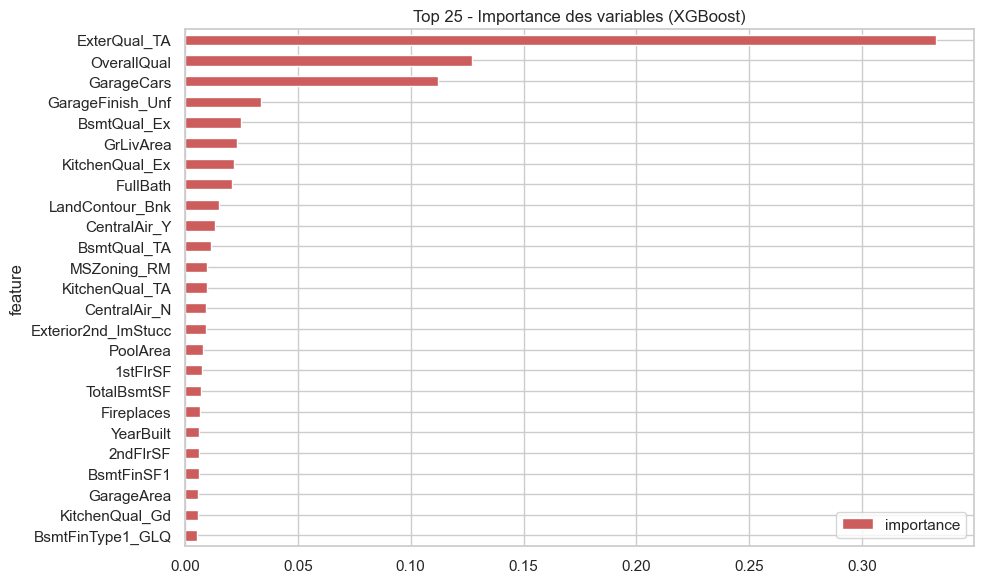

In [17]:
def get_feature_importance(model, numeric, categorical, top_n=20):
    preprocess_step = model.named_steps['preprocess']
    ohe = preprocess_step.named_transformers_['categorical'].named_steps['encoder']
    feature_names = numeric + list(ohe.get_feature_names_out(categorical))
    booster = model.named_steps['model']
    importances = booster.feature_importances_
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    return importance_df.sort_values(by='importance', ascending=False).head(top_n)

importance_df = get_feature_importance(xgb_model, numeric_cols, categorical_cols, top_n=25)
ax = importance_df.sort_values('importance').plot.barh(x='feature', y='importance', color='indianred')
ax.set_title('Top 25 - Importance des variables (XGBoost)')
plt.tight_layout()
importance_df

In [18]:
joblib.dump(xgb_model, "mon_deuxieme_model.joblib")

['mon_deuxieme_model.joblib']